In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.metrics import confusion_matrix

In [2]:
import pandas as pd
ice = pd.read_excel('./iscream(크롤링).xlsx')
tsel = pd.read_excel('./tselpa(크롤링).xlsx')

In [3]:
#2675로우, 10컬럼
ice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2675 entries, 0 to 2674
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2675 non-null   int64 
 1   제목          2675 non-null   object
 2   시간          2675 non-null   object
 3   날짜          2675 non-null   object
 4   별점          2675 non-null   int64 
 5   리뷰제목        2675 non-null   object
 6   리뷰내용        2675 non-null   object
 7   연수분야        2675 non-null   object
 8   가격          2675 non-null   object
 9   대상          2675 non-null   object
dtypes: int64(2), object(8)
memory usage: 209.1+ KB


In [4]:
#155로우, 10컬럼
tsel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  155 non-null    int64 
 1   제목          155 non-null    object
 2   시간          155 non-null    object
 3   날짜          155 non-null    object
 4   별점          155 non-null    int64 
 5   리뷰제목        155 non-null    object
 6   리뷰내용        155 non-null    object
 7   연수 분야       151 non-null    object
 8   가격          151 non-null    object
 9   대상          151 non-null    object
dtypes: int64(2), object(8)
memory usage: 12.2+ KB


In [5]:
# 'Unnamed: 0' 열 제거
if 'Unnamed: 0' in ice.columns:
    ice = ice.drop(columns=['Unnamed: 0'])

ice = ice.dropna(subset=['별점'])

# 별점 기준 라벨링:5점은 긍정(1), 1-4점은 부정(0)
ice['label'] = ice['별점'].apply(lambda x: 1 if x > 4 else 0)

In [6]:
len(ice[ice['label']=='0'])

0

In [7]:
from konlpy.tag import Okt
okt = Okt()
stop_words = set(['에게','함께','미술','이야기','하면','제','활동','있어서','어떻게','버전','유튜브','페이지','패들렛','사이트','다소','릿','각도','하시','안배','그림','특별','사람','표현','됩니다','평소','강','있게','이번','되고','현장','그림책','참','우리','꼭','있어','있었습니다','연','하는데','아이스크림','하며','하면서','학년','관련','되는','저','여행','게','영어','대해','시간','생각','노션','후기','였습니다','되었습니다','합니다','학기','했습니다','우리나라','너무나','부터','후기','만','통해','화용론','아이','감사합니다','많은','그게','여학생','남학생','듣고','것', '너무','있는','하는','에서','로','더','을','학생','대한','많이','내용','마음','하고','감사','정말','수업','강의','연수','할','수','적','인','분','입니다','의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다'])

In [8]:
def clean_text(text):
    text = re.sub('[^가-힣\s]', '', text)  
    tokens = okt.morphs(text)
    return tokens


ice['tokens'] = ice['리뷰내용'].apply(clean_text)

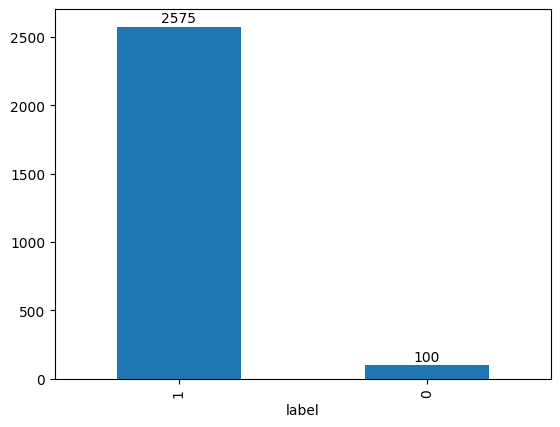

In [10]:
#긍정 2575, 부정100
import matplotlib.pyplot as plt

value_counts = ice['label'].value_counts()

ax = value_counts.plot(kind='bar')


for i, v in enumerate(value_counts):
    ax.text(i, v + 10, str(v), ha='center', va='bottom')
plt.show()

In [12]:
#데이터 불균형 -> 언더샘플링
Training_data_0 = ice[ice['label'] == 0]
Training_data_1 = ice[ice['label'] == 1].sample(300, random_state=42)
Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1, random_state=42).reset_index(drop=True)

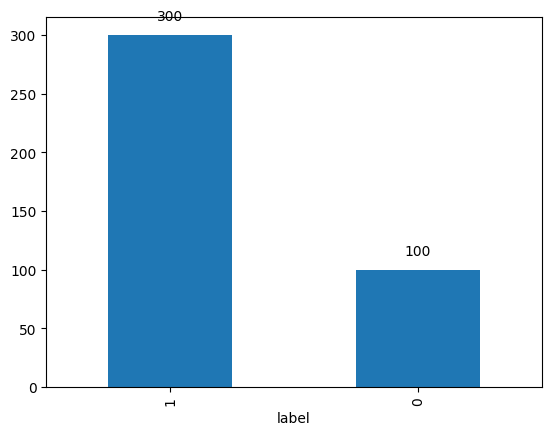

In [13]:
import matplotlib.pyplot as plt

# 레이블 값의 카운트 계산
value_counts = Undersample_data['label'].value_counts()

# 막대 그래프 그리기
ax = value_counts.plot(kind='bar')

# 막대 위에 숫자 표시하기
for i, v in enumerate(value_counts):
    ax.text(i, v + 10, str(v), ha='center', va='bottom')
plt.show()

In [15]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(Undersample_data['리뷰내용'])
y = Undersample_data['label']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
from sklearn.model_selection import GridSearchCV


sample_sizes = range(200, 2500, 100)
train_accuracy_results = []
test_accuracy_results = []
cv_accuracy_results = []
recall_results = []

# 고정된 random_state를 사용하여 데이터 샘플링 유지
for size in sample_sizes:
    # 언더샘플링
    Training_data_0 = ice[ice['label'] == 0].sample(size, random_state=41)
    Training_data_1 = ice[ice['label'] == 1]
    Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1, random_state=41).reset_index(drop=True)

    # 특성과 타겟 변수 분리
    data_input_reduced = Undersample_data.drop(columns=['Bankrupt?'])
    data_target = Undersample_data['Bankrupt?']



    # 랜덤 포레스트 모델 정의
    rf = RandomForestClassifier(random_state=42)
    sample_sizes = range(200, 2500, 100)


    # 그리드 서치 파라미터 설정
    param_grid = {
        'n_estimators': [100, 150, 200],  # 적절한 수의 나무
        'max_depth': [10, 20, 30, 40],    # 최대 깊이 제한
        'min_samples_split': [5, 10, 15], # 분할에 필요한 최소 샘플 수
        'min_samples_leaf': [2, 4, 6],    # 리프 노드에 필요한 최소 샘플 수
        'bootstrap': [True, False]        # 부트스트래핑 여부
    }

    # 그리드 서치 정의
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='accuracy')

    # 그리드 서치 학습
    grid_search.fit(X_train, y_train)

    # 최적의 하이퍼파라미터 출력
    print(f"Best parameters found: {grid_search.best_params_}")

    # 최적 모델로 예측
    best_rf = grid_search.best_estimator_
    y_train_pred = best_rf.predict(X_train)
    y_test_pred = best_rf.predict(X_test)

    # 평가
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_loss = log_loss(y_train, best_rf.predict_proba(X_train))
    test_loss = log_loss(y_test, best_rf.predict_proba(X_test))
    recall = recall_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    cv_accuracy = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy').mean()

    target_counts = y_test.value_counts()

    # 혼동 행렬 계산
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # 평가 결과 출력
    print(f"훈련 세트 정확도: {train_accuracy:.4f}")
    print(f"훈련 세트 손실: {train_loss:.4f}")
    print(f"테스트 세트 정확도: {test_accuracy:.4f}")
    print(f"테스트 세트 손실: {test_loss:.4f}")
    print(f"테스트 세트 정밀도: {precision:.4f}")
    print(f"테스트 세트 재현율: {recall:.4f}")
    print(f"테스트 세트 F1 점수: {f1:.4f}")
    print(f"교차 검증 평균 정확도: {cv_accuracy:.4f}")

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(sample_sizes, train_accuracy, marker='o', label='Train Accuracy')
    plt.plot(sample_sizes, test_accuracy, marker='o', label='Test Accuracy')
    plt.plot(sample_sizes, cv_accuracy, marker='o', label='Cross-Validation Accuracy')
    plt.plot(sample_sizes, recall, marker='o', label='Recall')
    plt.xlabel('Sample Size')
    plt.ylabel('Score')
    plt.title('Model Performance vs. Sample Size')
    plt.legend()
    plt.grid(True)
    plt.show()

ValueError: Cannot take a larger sample than population when 'replace=False'